# Sentiment Analysis

In [10]:
# loading libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re

In [11]:
# loading the imdb dataset
imdb = pd.read_csv('data/imdb_labelled.txt' , delimiter='\t', header=None, names=['review', 'sentiment'])
print(imdb.shape)

# loading the amazon dataset
amazon = pd.read_csv('data/amazon_cells_labelled.txt', delimiter='\t', header=None, names=['review', 'sentiment'])
print(amazon.shape)

# loading the yelp dataset
yelp = pd.read_csv('data/yelp_labelled.txt', delimiter='\t', header=None, names=['review', 'sentiment'] )
print(yelp.shape)

(748, 2)
(1000, 2)
(1000, 2)


In [12]:
dataset = imdb

In [13]:
dataset.head()

,review,sentiment
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo i...,1


In [14]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     748 non-null    object
 1   sentiment  748 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 11.8+ KB


In [15]:
dataset.isnull().sum()

review       0
sentiment    0
dtype: int64

In [16]:
dataset.sentiment.value_counts()

1    386
0    362
Name: sentiment, dtype: int64

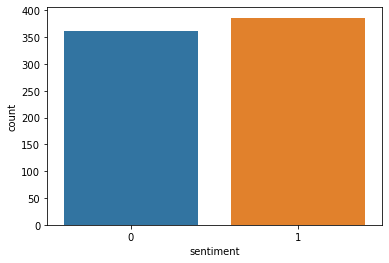

In [17]:
sns.countplot(x='sentiment', data=dataset)
plt.show()

In [18]:
# a method to remove special characters
def remove_special_characters(text):

    text = text.replace('-', ' ')
    text = text.replace('\t', '')
    text = text.replace('\n', '')
    text = text.replace(' +', '')
    
    pattern = r'[^a-zA-z\s]'
    
    text = re.sub(pattern, '', text)
    text = text.rstrip()

    return text

dataset['review'] = dataset['review'].apply(remove_special_characters)

In [19]:
# divide the dataset into train, development & test
# first the train & test data with 80 & 20 ratio
ratio = 0.8

train_len = int(ratio * len(dataset))
total_train_data = dataset[0:train_len]
test_dataset = dataset[train_len:]

# now divide into val dataset from training dataset with 80 & 20 ratio
new_train_len = int(ratio * len(total_train_data))

train_dataset = total_train_data[0:new_train_len]
val_dataset = total_train_data[new_train_len:]

print(f'training data shape: {train_dataset.shape}')
print(f'validation/development data shape: {val_dataset.shape}')
print(f'testing data shape: {test_dataset.shape}')

training data shape: (478, 2)
validation/development data shape: (120, 2)
testing data shape: (150, 2)


In [20]:
# divide the train dataset into feature (X) & label(y)
X_train = train_dataset['review']
y_train = train_dataset['sentiment']

In [22]:
review_0_train = train_dataset.loc[train_dataset.sentiment == 0]
print(f'Total 0 (negative) review in train dataset : {len(review_0_train)}')

review_1_train = train_dataset.loc[train_dataset.sentiment == 1]
print(f'Total 1 (positive) review in train dataset : {len(review_1_train)}')

Total 0 (negative) review in train dataset : 267
Total 1 (positive) review in train dataset : 211


## Prior Probabilities

In [23]:
# let's calculate the prior class (0 & 1) probabilities
def calculate_prior_class_prob(y_train):
  prior_class_prob = {}
  for c in np.unique(y_train):
    count = sum(y_train == c)
    prior_class_prob[c] = count / y_train.size
  return prior_class_prob

prior_class_prob = calculate_prior_class_prob(y_train)
print(f'prior probability of class 0 (negative) : {prior_class_prob[0]}')
print(f'prior probability of class 1 (positive) : {prior_class_prob[1]}')

prior probability of class 0 (negative) : 0.5585774058577406
prior probability of class 1 (positive) : 0.44142259414225943


In [ ]:
# 
stop_words_list = ['those', 'on', 'own', 'yourselves', 'ie', 'around', 'between', 'four', 'been', 'alone', 'off', 'am', 'then', 'other', 'can', 'cry', 'regarding', 'hereafter', 'front', 'too', 'used', 'wherein', 'doing', 'everything', 'up', 'never', 'onto', 'how', 'either', 'before', 'anyway', 'since', 'through', 'amount', 'now', 'he', 'cant', 'was', 'con', 'have', 'into', 'because', 'inc', 'not', 'therefore', 'they', 'even', 'whom', 'it', 'see', 'somewhere', 'interest', 'thereupon', 'thick', 'nothing', 'whereas', 'much', 'whenever', 'find', 'seem', 'until', 'whereby', 'at', 'ltd', 'fire', 'also', 'some', 'last', 'than', 'get', 'already', 'our', 'doesn', 'once', 'will', 'noone', 'that', 'what', 'thus', 'no', 'myself', 'out', 'next', 'whatever', 'although', 'though', 'etc', 'which', 'would', 'therein', 'nor', 'somehow', 'whereupon', 'besides', 'whoever', 'thin', 'ourselves', 'few', 'did', 'third', 'without', 'twelve', 'anything', 'against', 'while', 'twenty', 'if', 'however', 'found', 'herself', 'when', 'may', 'six', 'ours', 'done', 'seems', 'else', 'call', 'perhaps', 'had', 'nevertheless', 'fill', 'where', 'otherwise', 'still', 'within', 'its', 'for', 'together', 'elsewhere', 'throughout', 'of', 'eg', 'others', 'show', 'sincere', 'anywhere', 'anyhow', 'as', 'are', 'the', 'hence', 'something', 'hereby', 'nowhere', 'latterly', 'de', 'say', 'does', 'neither', 'his', 'go', 'forty', 'put', 'their', 'by', 'namely', 'km', 'could', 'five', 'unless', 'itself', 'is', 'nine', 'whereafter', 'down', 'bottom', 'thereby', 'such', 'both', 'she', 'become', 'whole', 'who', 'yourself', 'every', 'thru', 'except', 'very', 'several', 'among', 'being', 'be', 'mine', 'further', 'here', 'during', 'why', 'with', 'just', 'becomes', 'about', 'a', 'co', 'using', 'seeming', 'due', 'wherever', 'beforehand', 'detail', 'fifty', 'becoming', 'might', 'amongst', 'my', 'empty', 'thence', 'thereafter', 'almost', 'least', 'someone', 'often', 'from', 'keep', 'him', 'or', 'top', 'her', 'didn', 'nobody', 'sometime', 'across', 'hundred', 'only', 'via', 'name', 'eight', 'three', 'back', 'to', 'all', 'became', 'move', 'me', 'we', 'formerly', 'so', 'i', 'whence', 'describe', 'under', 'always', 'himself', 'more', 'herein', 'in', 'after', 'themselves', 'you', 'them', 'above', 'sixty', 'hasnt', 'your', 'made', 'everywhere', 'indeed', 'most', 'kg', 'fifteen', 'but', 'must', 'along', 'beside', 'hers', 'computer', 'side', 'former', 'full', 'anyone', 'has', 'yours', 'whose', 'behind', 'please', 'mill', 'amoungst', 'ten', 'seemed', 'sometimes', 'should', 'over', 'take', 'each', 'don', 'same', 'rather', 'really', 'latter', 'and', 'part', 'hereupon', 'per', 'eleven', 'ever', 'enough', 'again', 'us', 'yet', 'moreover', 'mostly', 'one', 'meanwhile', 'whither', 'there', 'toward', 'give', 'system', 'do', 'quite', 'an', 'these', 'everyone', 'towards', 'this', 'bill', 'cannot', 'un', 'afterwards', 'beyond', 'make', 'were', 'whether', 'well', 'another', 'below', 'first', 'upon', 'any', 'none', 'many', 'various', 'serious', 're', 'two', 'less', 'couldnt']

def remove_stop_words(vocab, word_freq):

  for word in vocab:
    if word in stop_words_lst:
      vocab.remove(word)
      del word_freq[word]
  return vocab, word_freq